# Crashes during Spring Break

Do crashes decrease during Denver Public Schools spring breaks?

In [1]:
import json
import pytz
import folium
from folium.features import DivIcon
from folium.plugins import HeatMap

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib._color_data import TABLEAU_COLORS
import seaborn as sns

import os
os.chdir('..')

pd.set_option('display.max_rows', 500)

from scripts.crash_data_analysis import CrashDataAnalysis

In [2]:
cda = CrashDataAnalysis()

## Days of Spring Breaks

* 2025: 3/24-3/31 (extra day cesar chavez day)
* 2024: 3/25-4/1 (extra day cesar chavez day)
* 2023: 3/27-4/3 (extra day cesar chavez day)
* 2022: 3/28-4/4 (extra day cesar chavez day)
* 2021: 3/29-4/2 (no extra day)
* 2020: 3/30-4/3 (also COVID, so no school)
* 2019: 3/25-2/29
* 2018: 3/26-3/30
* 2017: 3/28-4/1

In [3]:
spring_breaks = [
    [datetime(2017, 3, 28), datetime(2017, 4, 1)]
    , [datetime(2018, 3, 26), datetime(2018, 3, 30)]
    , [datetime(2019, 3, 25), datetime(2019, 3, 29)]
    , [datetime(2021, 3, 29), datetime(2021, 4, 2)]
    , [datetime(2022, 3, 28), datetime(2022, 4, 4)]
    , [datetime(2023, 3, 27), datetime(2023, 4, 3)]
    , [datetime(2024, 3, 25), datetime(2024, 4, 1)]
    , [datetime(2025, 3, 24), datetime(2025, 3, 31)]
]

In [4]:
query = """
select
to_char(reported_date at time zone 'America/Denver', 'YYYY-MM-DD') as crash_date
, to_char(reported_date at time zone 'America/Denver', 'Mon FMDD') as crash_date_str
, count(*) as num_crashes

from crashes c

where date_part('year', reported_date at time zone 'America/Denver') > 2017

group by 1,2
order by 1
"""

crashes_by_day = pd.read_sql(query, cda.conn)

In [5]:
crashes_by_day['crash_date'] = pd.to_datetime(crashes_by_day['crash_date'])

In [6]:
crashes_by_day['day_of_week'] = crashes_by_day['crash_date'].dt.weekday
crashes_by_day['crash_year'] = crashes_by_day.crash_date.dt.year

In [7]:
crashes_by_day['is_spring_break'] = 'Not Spring Break'
for year in spring_breaks:
    crashes_by_day.loc[
        (
            (crashes_by_day.crash_date >= year[0])
            & (crashes_by_day.crash_date <= year[1])
            & (crashes_by_day.day_of_week != 5) # Saturday
            & (crashes_by_day.day_of_week != 6) # Sunday
        )
        , 'is_spring_break'
    ] = 'Spring Break'

In [8]:
# crashes_by_day.to_csv('~/Desktop/crashes_by_day.csv', index=False)

## Counts

In [9]:
crashes_by_day.groupby('is_spring_break').size()

is_spring_break
Not Spring Break    2629
Spring Break          39
dtype: int64

In [10]:
crashes_by_day.pivot_table(
    columns='is_spring_break'
    , index='crash_year'
    , values='num_crashes'
    , aggfunc='count'
    , fill_value=0
    , margins=True
    , margins_name='Total'
)

is_spring_break,Not Spring Break,Spring Break,Total
crash_year,,,
2018,360,5,365
2019,360,5,365
2020,366,0,366
2021,360,5,365
2022,359,6,365
2023,359,6,365
2024,360,6,366
2025,105,6,111
Total,2629,39,2668


In [11]:
effect_median = crashes_by_day.pivot_table(
    index='day_of_week'
    , columns='is_spring_break'
    , values='num_crashes'
    , aggfunc='median'
)
effect_median['delta'] = effect_median['Spring Break'] - effect_median['Not Spring Break']
effect_median

is_spring_break,Not Spring Break,Spring Break,delta
day_of_week,,,
0,54.0,46.0,-8.0
1,58.0,53.0,-5.0
2,57.0,48.0,-9.0
3,59.0,51.0,-8.0
4,57.5,50.0,-7.5
5,44.0,NaN,NaN
6,41.0,NaN,NaN


In [12]:
crashes_by_day.pivot_table(
    index='day_of_week'
    , columns='is_spring_break'
    , values='num_crashes'
    , aggfunc='count'
    , margins=True
    , margins_name='Total'
    , fill_value=0
)

is_spring_break,Not Spring Break,Spring Break,Total
day_of_week,,,
0,371,11,382
1,374,7,381
2,374,7,381
3,374,7,381
4,374,7,381
5,381,0,381
6,381,0,381
Total,2629,39,2668


In [13]:
effect_alldays_median = crashes_by_day[crashes_by_day.day_of_week <= 4].pivot_table(
    columns='is_spring_break'
    , values='num_crashes'
    , aggfunc='median'
)
effect_alldays_median['delta'] = effect_alldays_median['Spring Break'] - effect_alldays_median['Not Spring Break']
effect_alldays_median

is_spring_break,Not Spring Break,Spring Break,delta
num_crashes,57,51,-6


## Plots

In [14]:
max_crash_timestamp = crashes_by_day.crash_date.max() # most recent date from query

citation = f"""
Source: City and County of Denver "Traffic Accidents" dataset, updated {max_crash_timestamp.strftime('%b %-d, %Y')}
Chart by Devin Brady
"""

print(citation)


Source: City and County of Denver "Traffic Accidents" dataset, updated Apr 21, 2025
Chart by Devin Brady



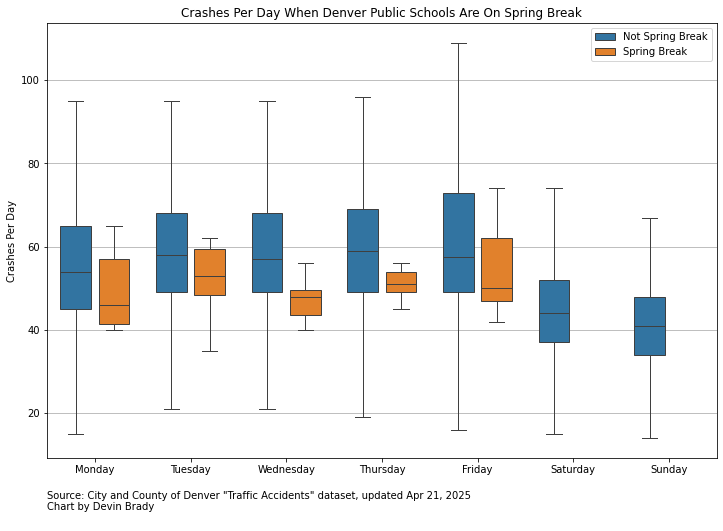

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(
    data=crashes_by_day
    , x='day_of_week'
    , y='num_crashes'
    , hue='is_spring_break'
    , ax=ax
    , showfliers=False
    , gap=0.2
)

plt.xlabel(None)
plt.ylabel('Crashes Per Day')
plt.title('Crashes Per Day When Denver Public Schools Are On Spring Break')
ax.set_xticks(
    ticks=ax.get_xticks()
    , labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
ax.grid(axis='y')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

ax.annotate(xy=(0, -0.1), text=citation, xycoords='axes fraction', ha='left', va='center')

plt.savefig('images/spring_break_boxplot.png', transparent=False, facecolor='white', bbox_inches='tight')